<a href="https://colab.research.google.com/github/JR-1991/Catalax/blob/master/examples/Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import catalax
except ImportError:
    !pip install git+https://github.com/JR-1991/Catalax.git

In [2]:
import json
import jax.numpy as jnp

import catalax as ctx

In [3]:
# Initialize the model
model = ctx.Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0
model.parameters.K_m.value = 100.0

model

Model summary


Eq(x, Matrix([[s1]]))

Eq(theta, Matrix([[v_max, K_m]]))

Eq(Derivative(s1, t), -s1*v_max/(K_m + s1))

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100.0,False,None,None,None,None
1,v_max,v_max,7.0,False,None,None,None,None


In [4]:
# Load data
data = jnp.load("./data/data.npy")
time = jnp.load("./data/time.npy")
initial_conditions = json.load(open("./data/initial_conditions.json", "r"))

print(f"Time: {time.shape} | Data: {data.shape}")

Time: (120, 6) | Data: (120, 6, 1)


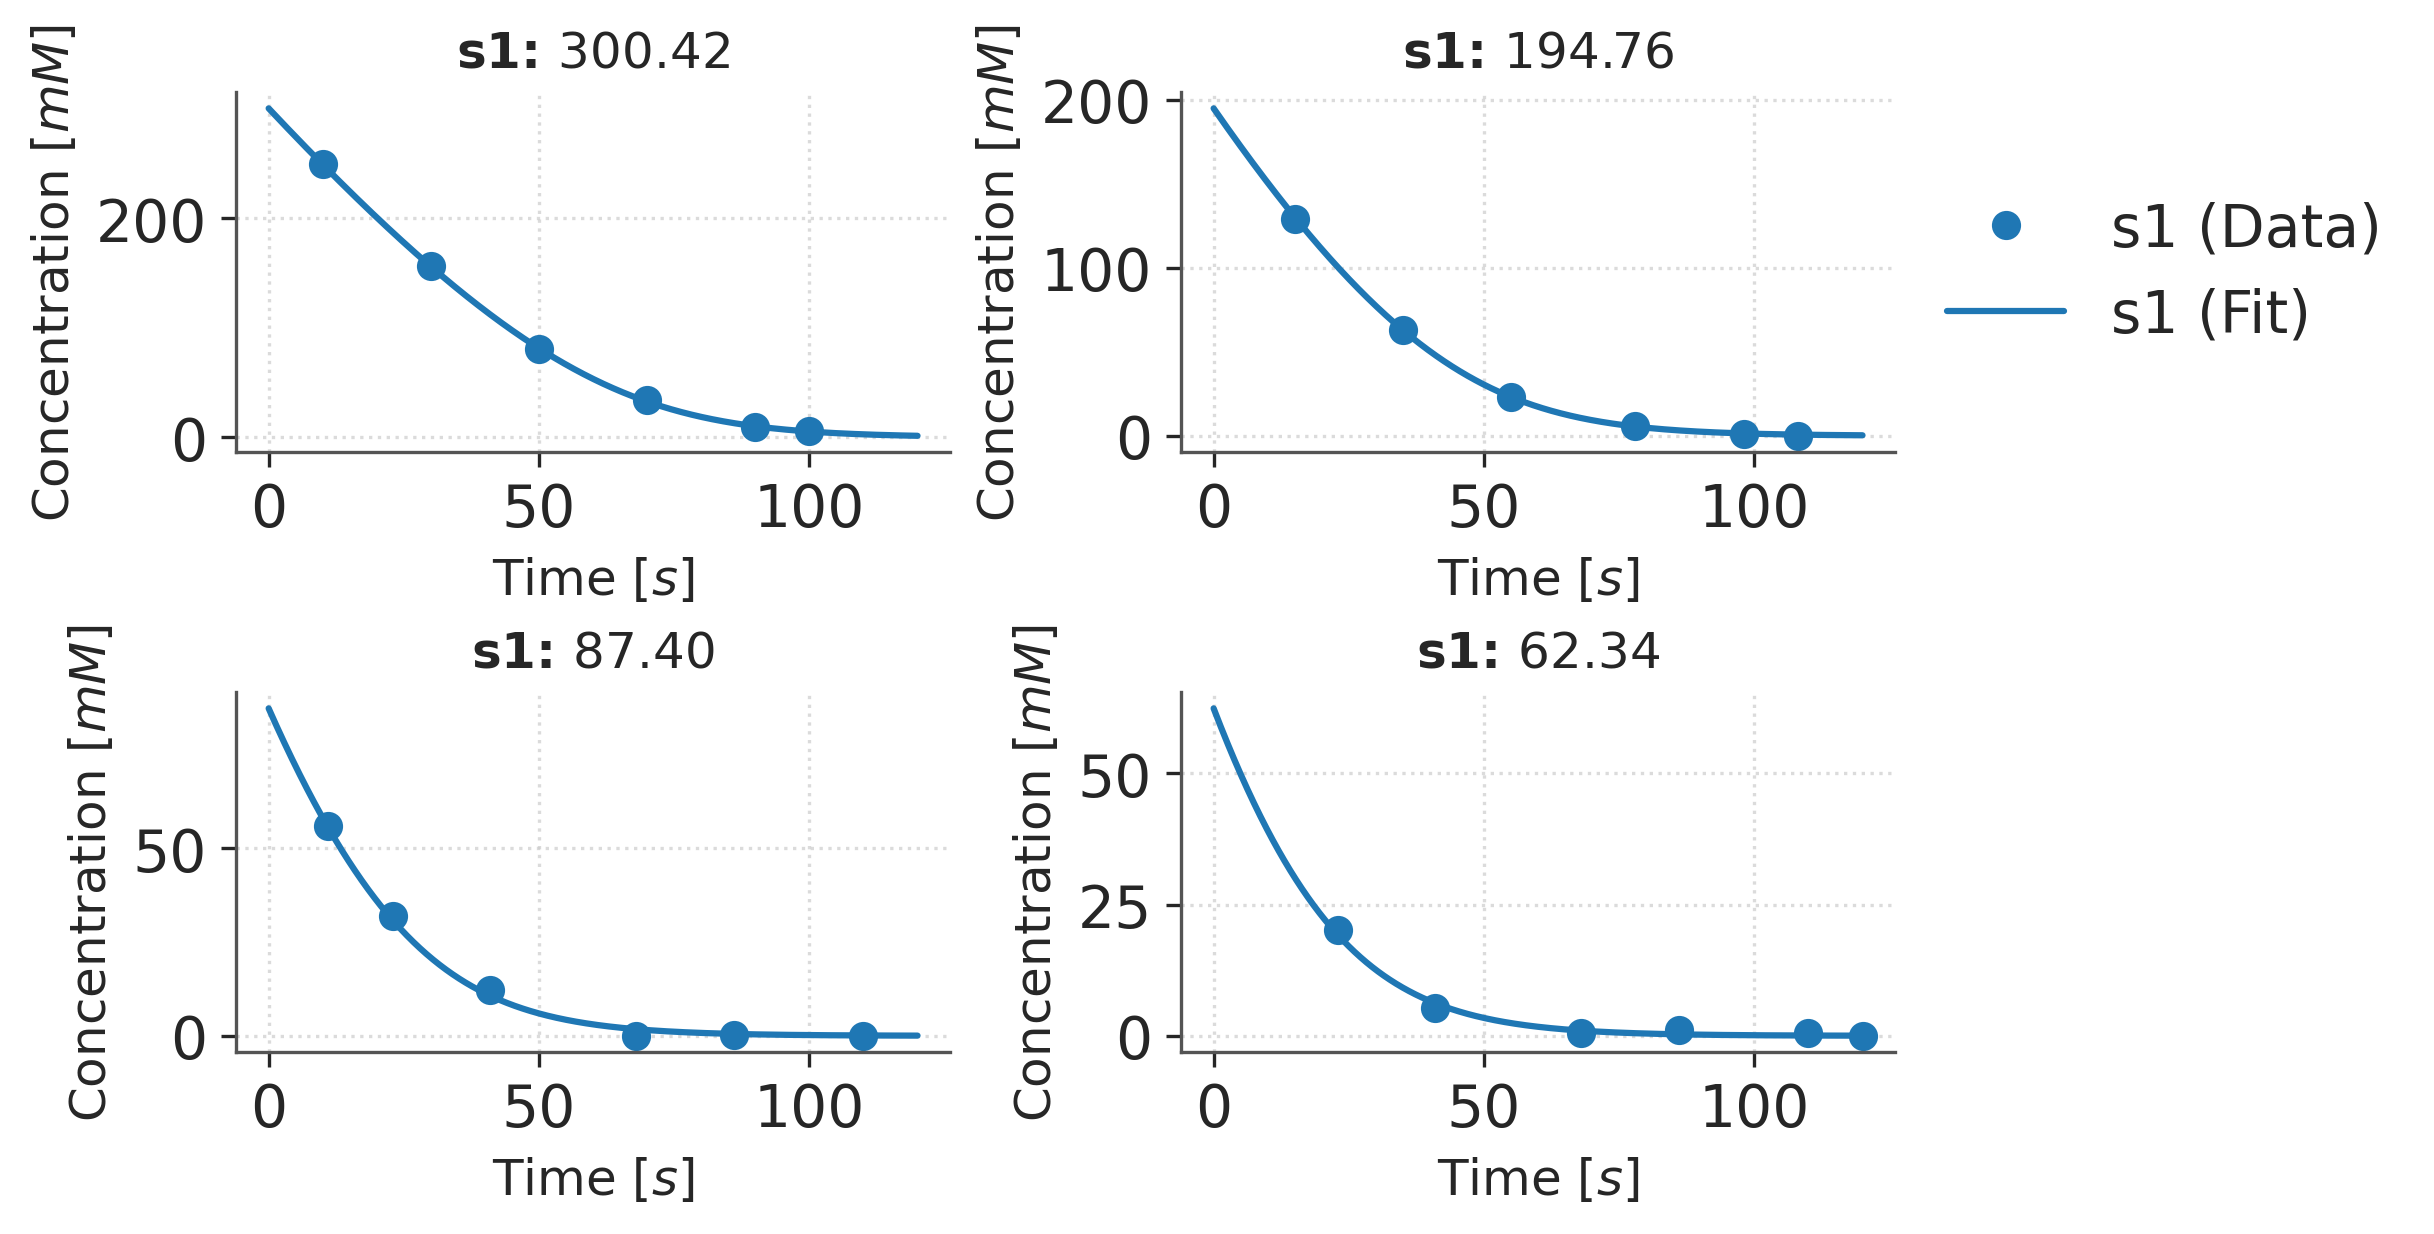

In [5]:
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(4,2),
)

In [6]:
# In order to perform optimization, we need to add initial values.
model.parameters.v_max.initial_value = 10.0
model.parameters.K_m.initial_value = 120.0

# ... and to make sure to be as realistic as possible.
model.parameters.v_max.value = None
model.parameters.K_m.value = None

In [7]:
# Perform the optimization
result, new_model = ctx.optimize(
    model=model,
    initial_conditions=initial_conditions,
    data=data,
    times=time,
    global_upper_bound=1e5,
    global_lower_bound=1e-6,
    method="bfgs"
)

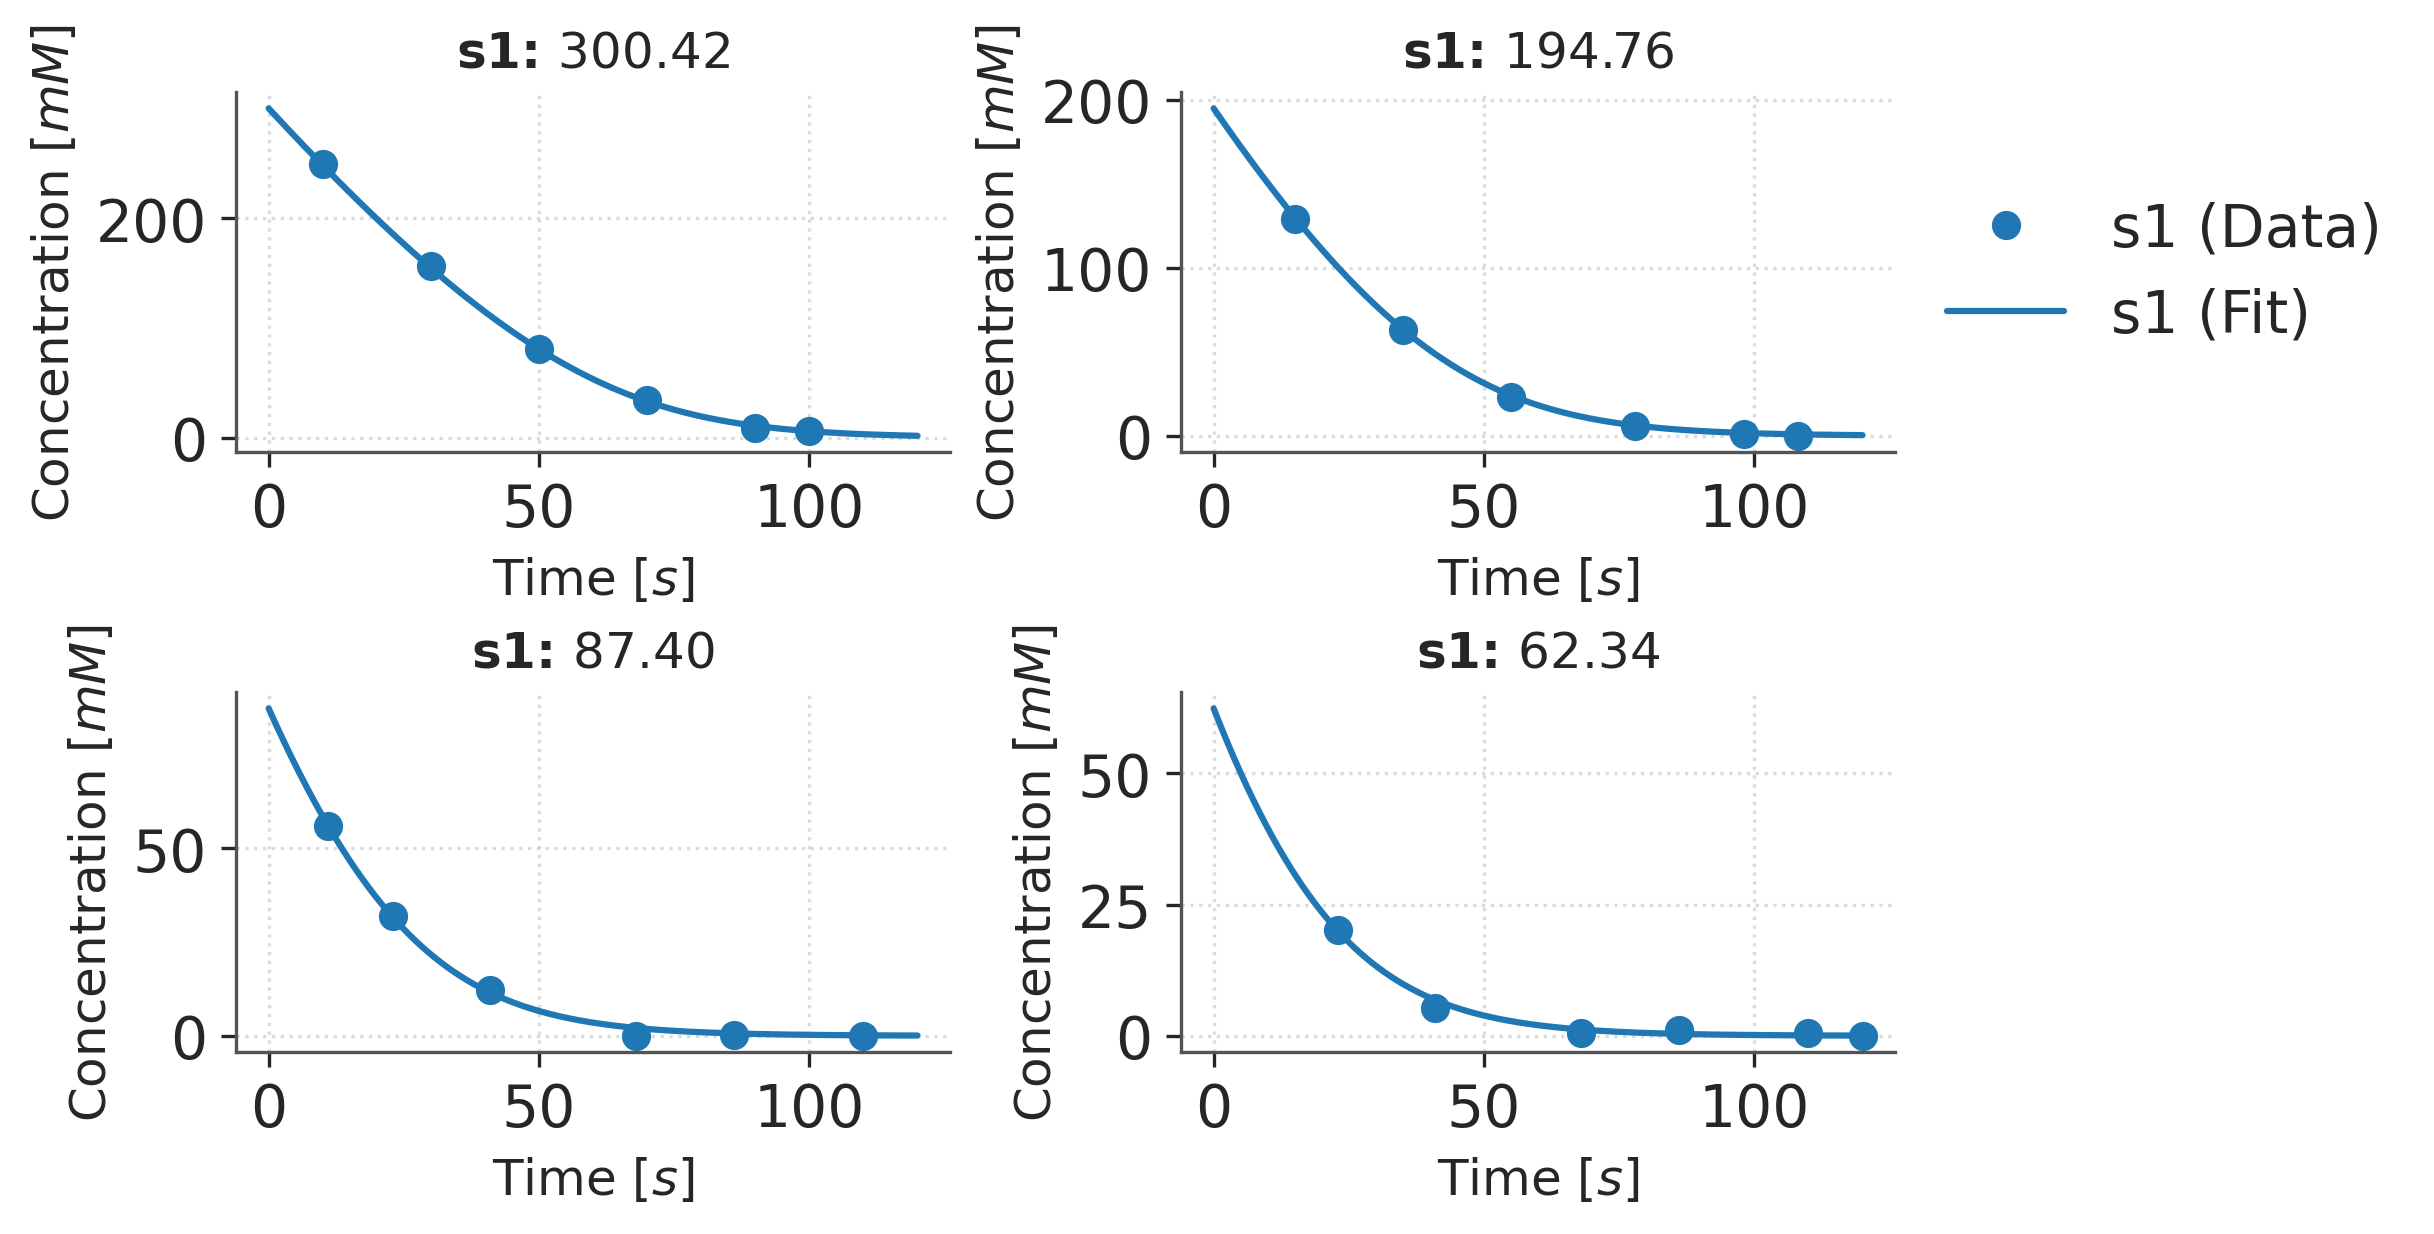

In [10]:
f = ctx.visualize(
    model=new_model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(4,2),
)